In [1]:
import os
from utils.constants import (
    CUDA_VISIBLE_DEVICES,
)
os.environ['CUDA_VISIBLE_DEVICES'] = CUDA_VISIBLE_DEVICES

import matplotlib.pyplot as plt
import torch
import pandas as pd
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

from pl_modules.DukePreMRI import DukePreMRI
from pl_models.FeaturesModModel import FeaturesModModel
from pl_models.FeaturesPredModel import FeaturesPredModel

from monai.utils import first

from utils.constants import (
    SPATIAL_SIZE,
    TRAIN_RATIO,
    VAL_RATIO,
    TEST_RATIO,
    FEATURE_MOD_CHECKPOINT_PATH,
    FEATURE_PRED_CHECKPOINT_PATH,
    DATASETS_PATH
)

# consants
BATCH_SIZE = 4

In [2]:
def display_sampled_imgs(samples):
    for img in samples:
        plt.style.use("default")
        plt.imshow(img[0].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()
        
        
def display_edited_imgs(edited_imgs):
    og_img,edited_img,noisy_img = edited_imgs
    
    for i in range(og_img.shape[0]):
        plt.figure(figsize=(12,6))
        plt.style.use("default")
        plt.subplot(1,3,1)
        plt.title('edited_img')
        plt.imshow(edited_img[i,0].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.subplot(1,3,2)
        plt.title('og_img')
        plt.imshow(og_img[i,0].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.subplot(1,3,3)
        plt.title('noisy_img')
        plt.imshow(noisy_img[i,0].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()

In [3]:
datamodule = DukePreMRI(batch_size=BATCH_SIZE,
                        test_batch_size=BATCH_SIZE*3,
                        train_ratio=TRAIN_RATIO,
                        val_ratio=VAL_RATIO,
                        test_ratio=TEST_RATIO,
                        subset=0.01
)

datamodule.prepare_data()
datamodule.setup(stage='test')

test_batch = first(datamodule.test_dataloader())
test_batch['image'],test_batch['features'] = test_batch['image'].to('cuda'),test_batch['features'].to('cuda')

classifier_model = FeaturesPredModel.load_from_checkpoint(FEATURE_PRED_CHECKPOINT_PATH)
classifier_model.eval()

model = FeaturesModModel.load_from_checkpoint(FEATURE_MOD_CHECKPOINT_PATH)
model.eval()

model.hparams.model_hparams['batch_size'] = BATCH_SIZE

Loading dataset: 100%|██████████| 156/156 [00:05<00:00, 26.31it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:26<00:00,  1.92it/s]


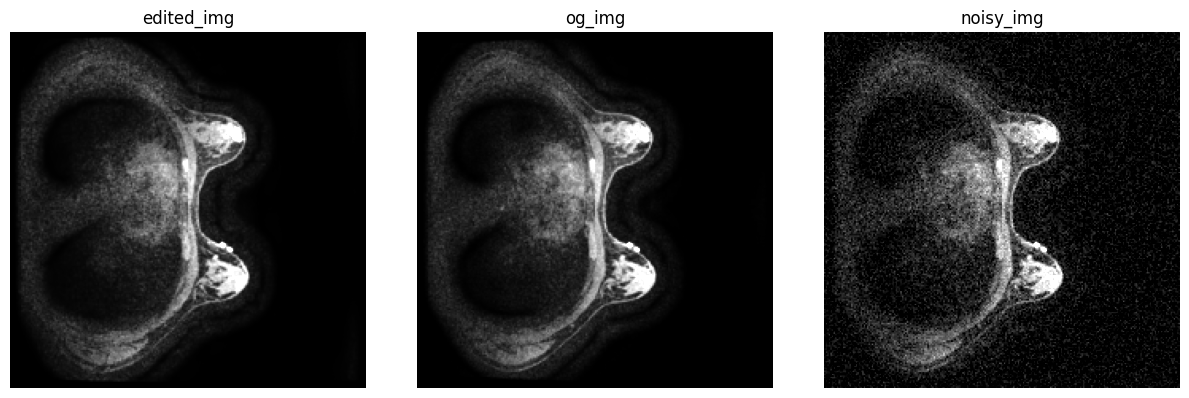

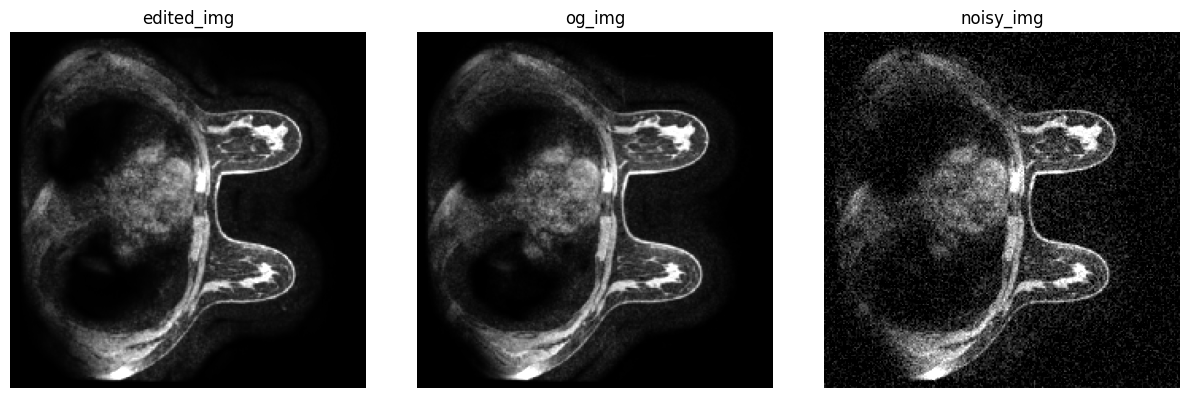

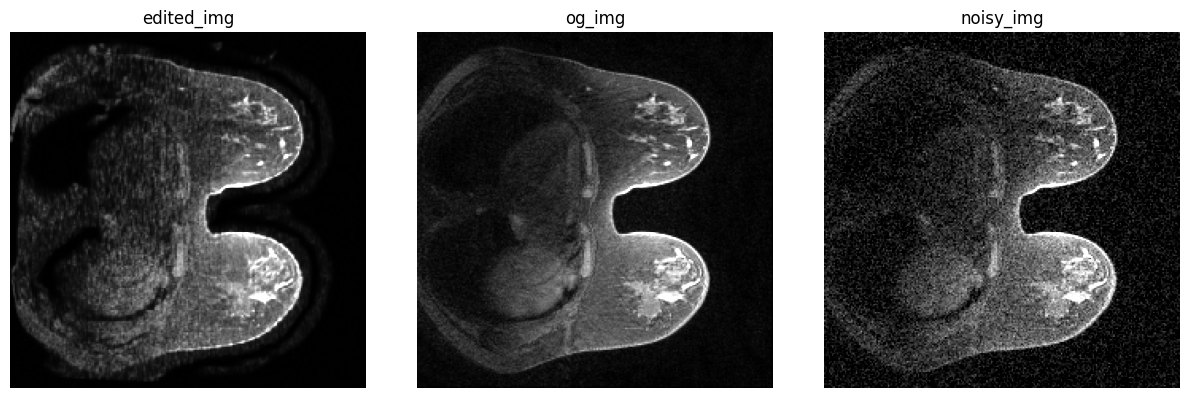

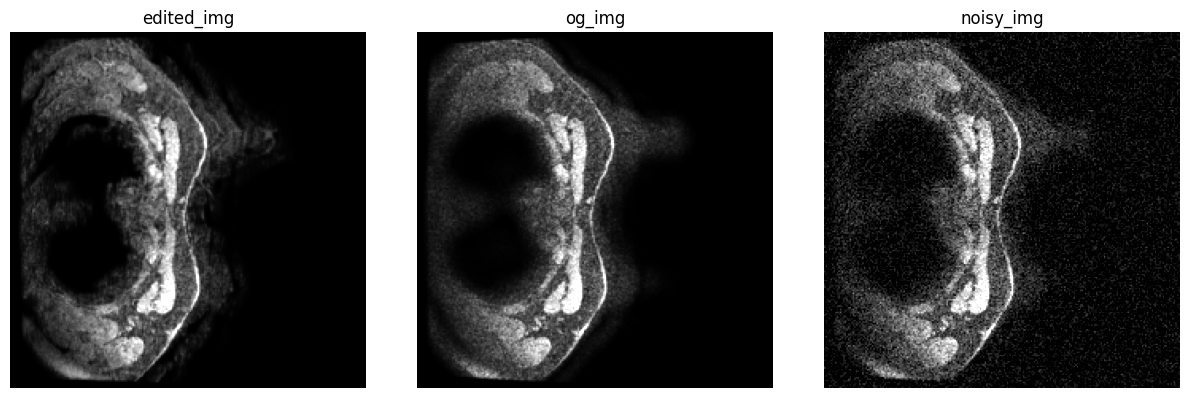

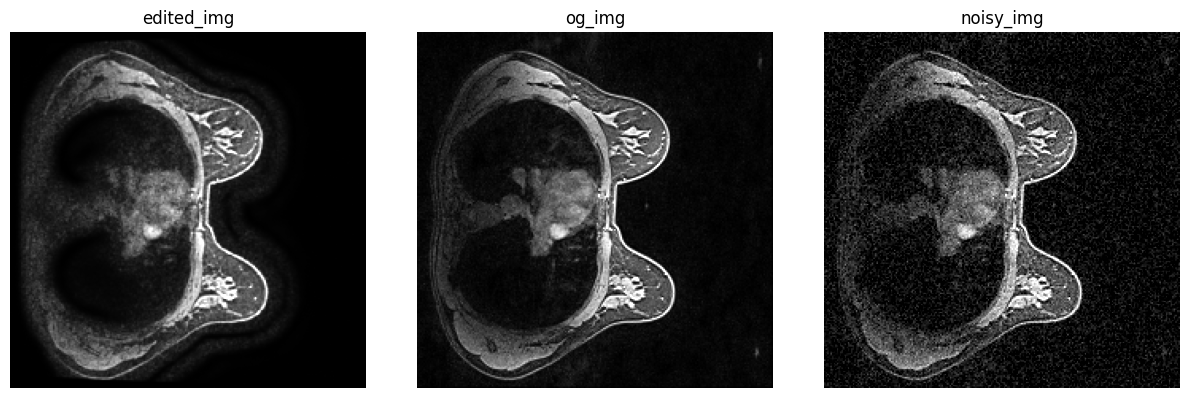

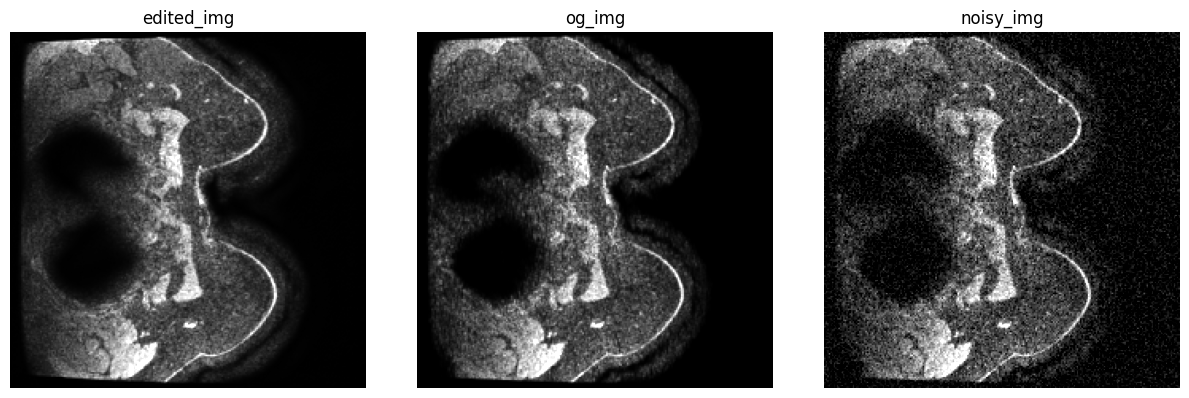

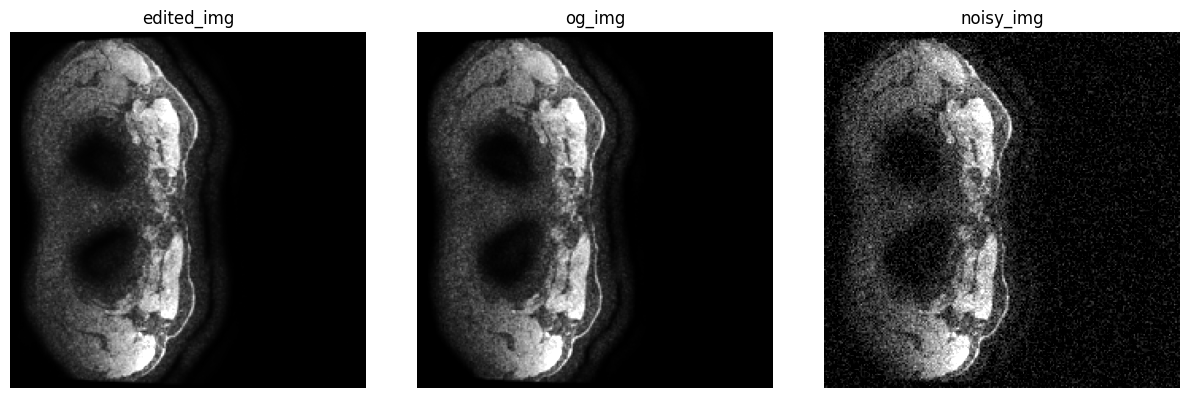

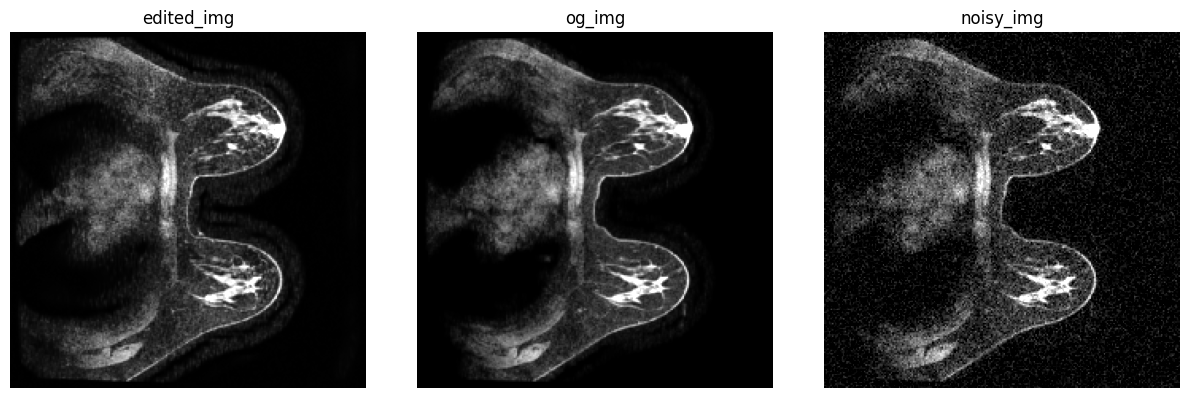

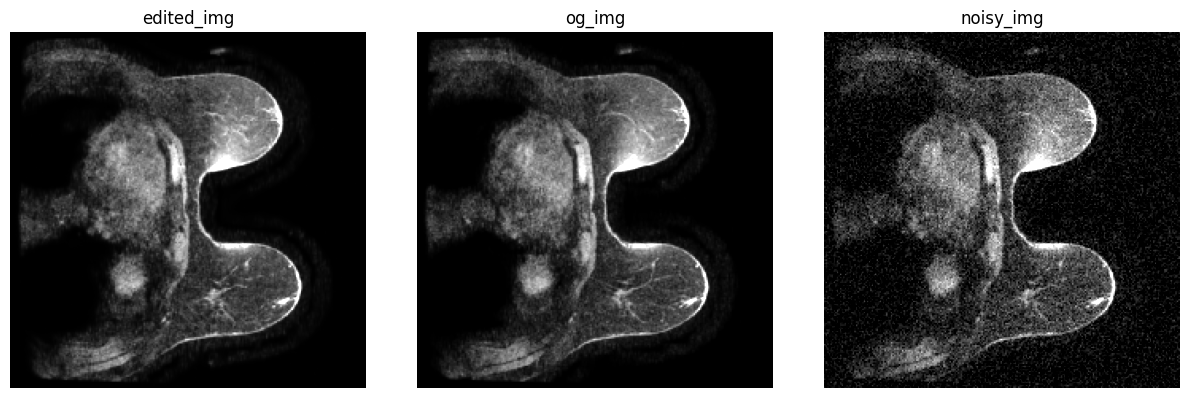

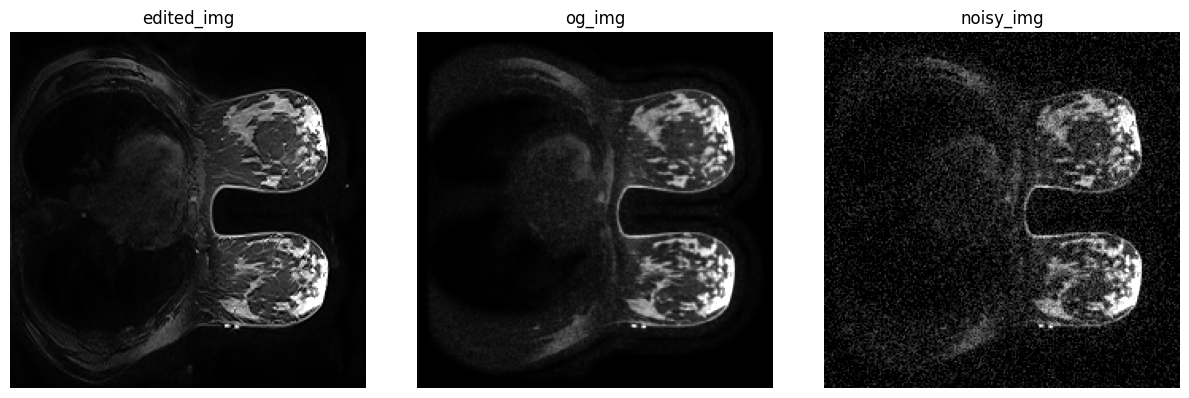

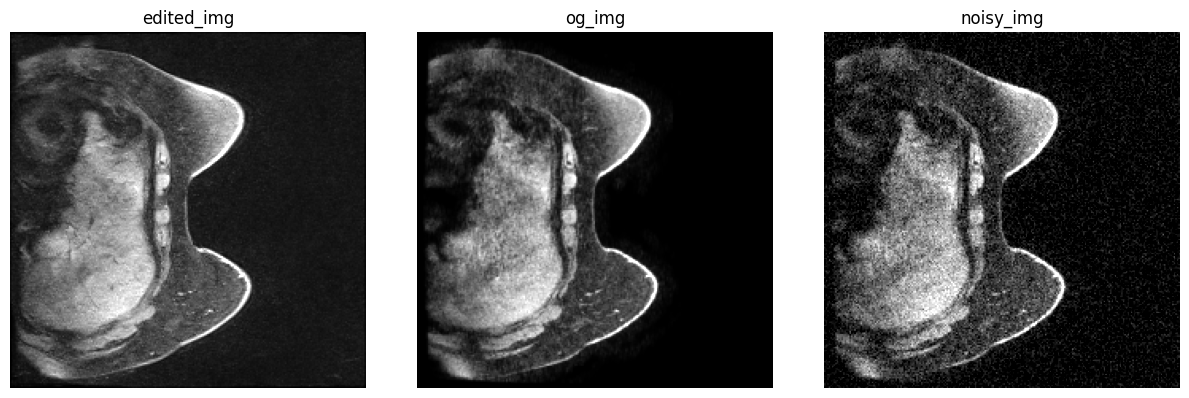

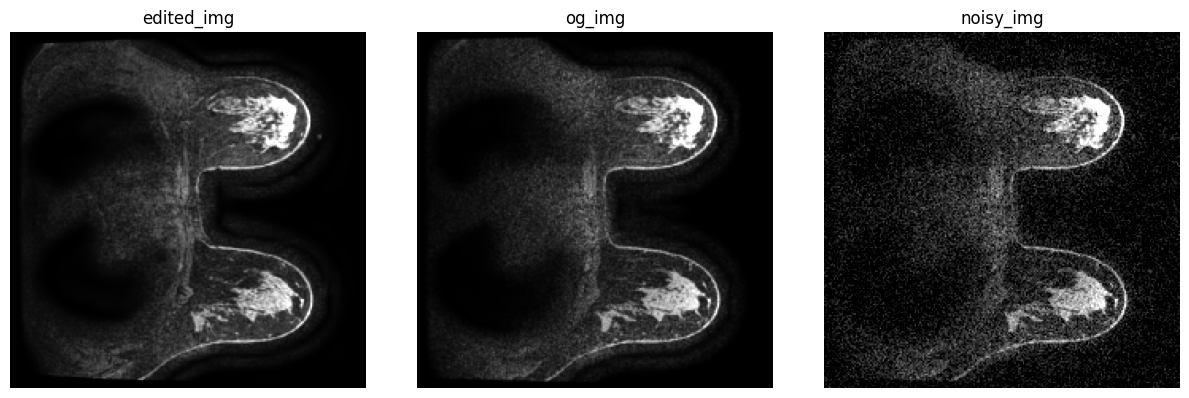

In [6]:
model.hparams.test_params = {'guidance_scale': 5, 'steps': 50}

edited_imgs = model.edit(imgs=test_batch['image'],
                    features=test_batch['features'][torch.randperm(test_batch['features'].shape[0])],
                    start_t = model.hparams.test_params['steps'],
                    guidance_scale = model.hparams.test_params['guidance_scale'])

display_edited_imgs(edited_imgs)

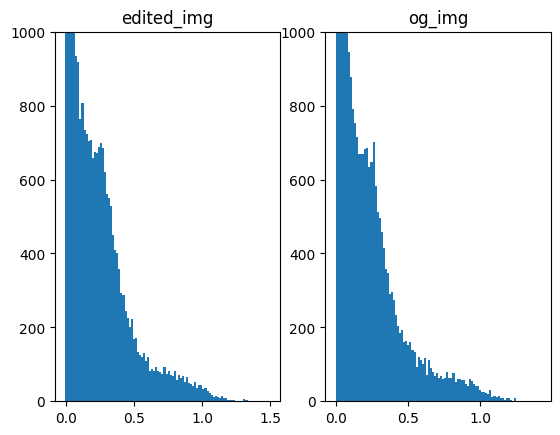

In [11]:
plt.style.use("default")
plt.subplot(1,2,1)
plt.title('edited_img')
plt.hist(edited_imgs[1][3].flatten().cpu(), bins=100)
plt.ylim([0,1000])
plt.subplot(1,2,2)
plt.title('og_img')
plt.hist(edited_imgs[0][3].flatten().cpu(), bins=100)
plt.ylim([0,1000])
plt.show()